# House Predicting

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [2]:
# Import the 'warnings' module and configure it to ignore warnings
import warnings

# The 'warnings.filterwarnings' function is used to filter and handle warnings.
# In this case, it's configured to ignore all warnings ('ignore').
warnings.filterwarnings('ignore')

## Importing data and Preprocessing

In [3]:
train = pd.read_csv("train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test = pd.read_csv("test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

In [7]:
train.select_dtypes(include=["int64","float64"]).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [8]:
len(train.select_dtypes(include=["int64","float64"]).columns)

38

In [9]:
train.select_dtypes(include=["object"]).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [10]:
len(train.select_dtypes(include=["object"]).columns)

43

In [11]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [12]:
train.describe(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [14]:
train[train.columns[train.isna().any()]].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [15]:
len(train.select_dtypes(include=["int64","float64"]).columns)

38

In [16]:
len(train.select_dtypes(include=["object"]).columns)

43

In [17]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'SalePrice distribution')

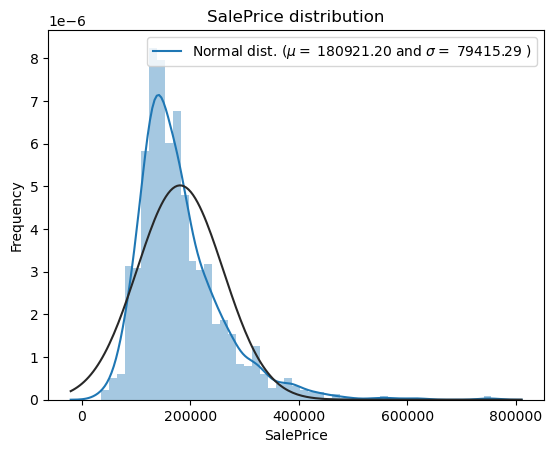

In [18]:
(mu,sigma) = norm.fit(train["SalePrice"])
sns.distplot(train['SalePrice'] , fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

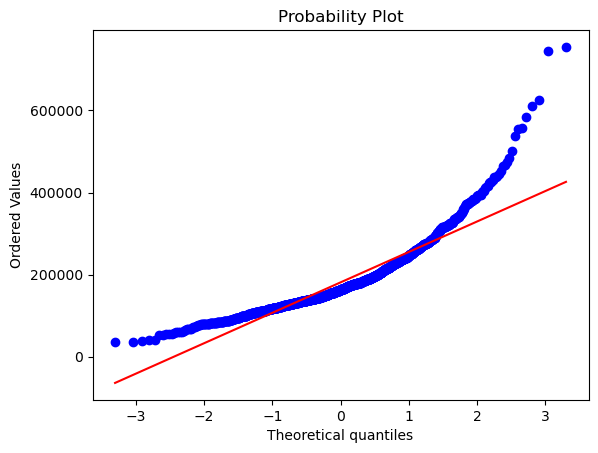

Skewness: 1.882876
Kurtosis: 6.536282


In [19]:
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

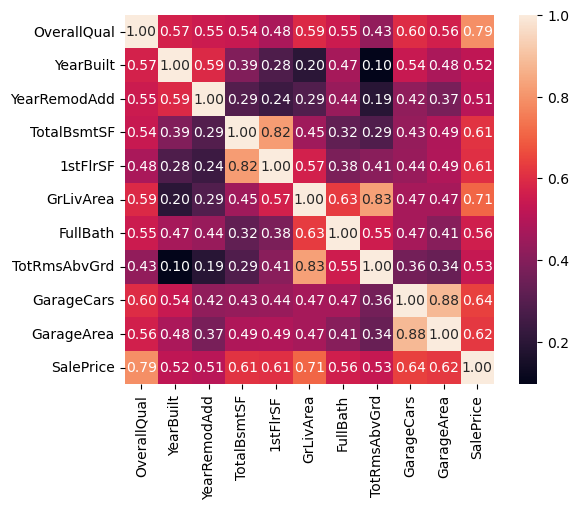

In [20]:
corr = train.corr()
correlation_threshold = 0.5
correlation_with_saleprice = corr['SalePrice'].abs()
relevant_cols = correlation_with_saleprice[correlation_with_saleprice > correlation_threshold].index

cm = np.corrcoef(train[relevant_cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=relevant_cols.values, xticklabels=relevant_cols.values)
plt.show()


In [21]:
relevant_cols

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')

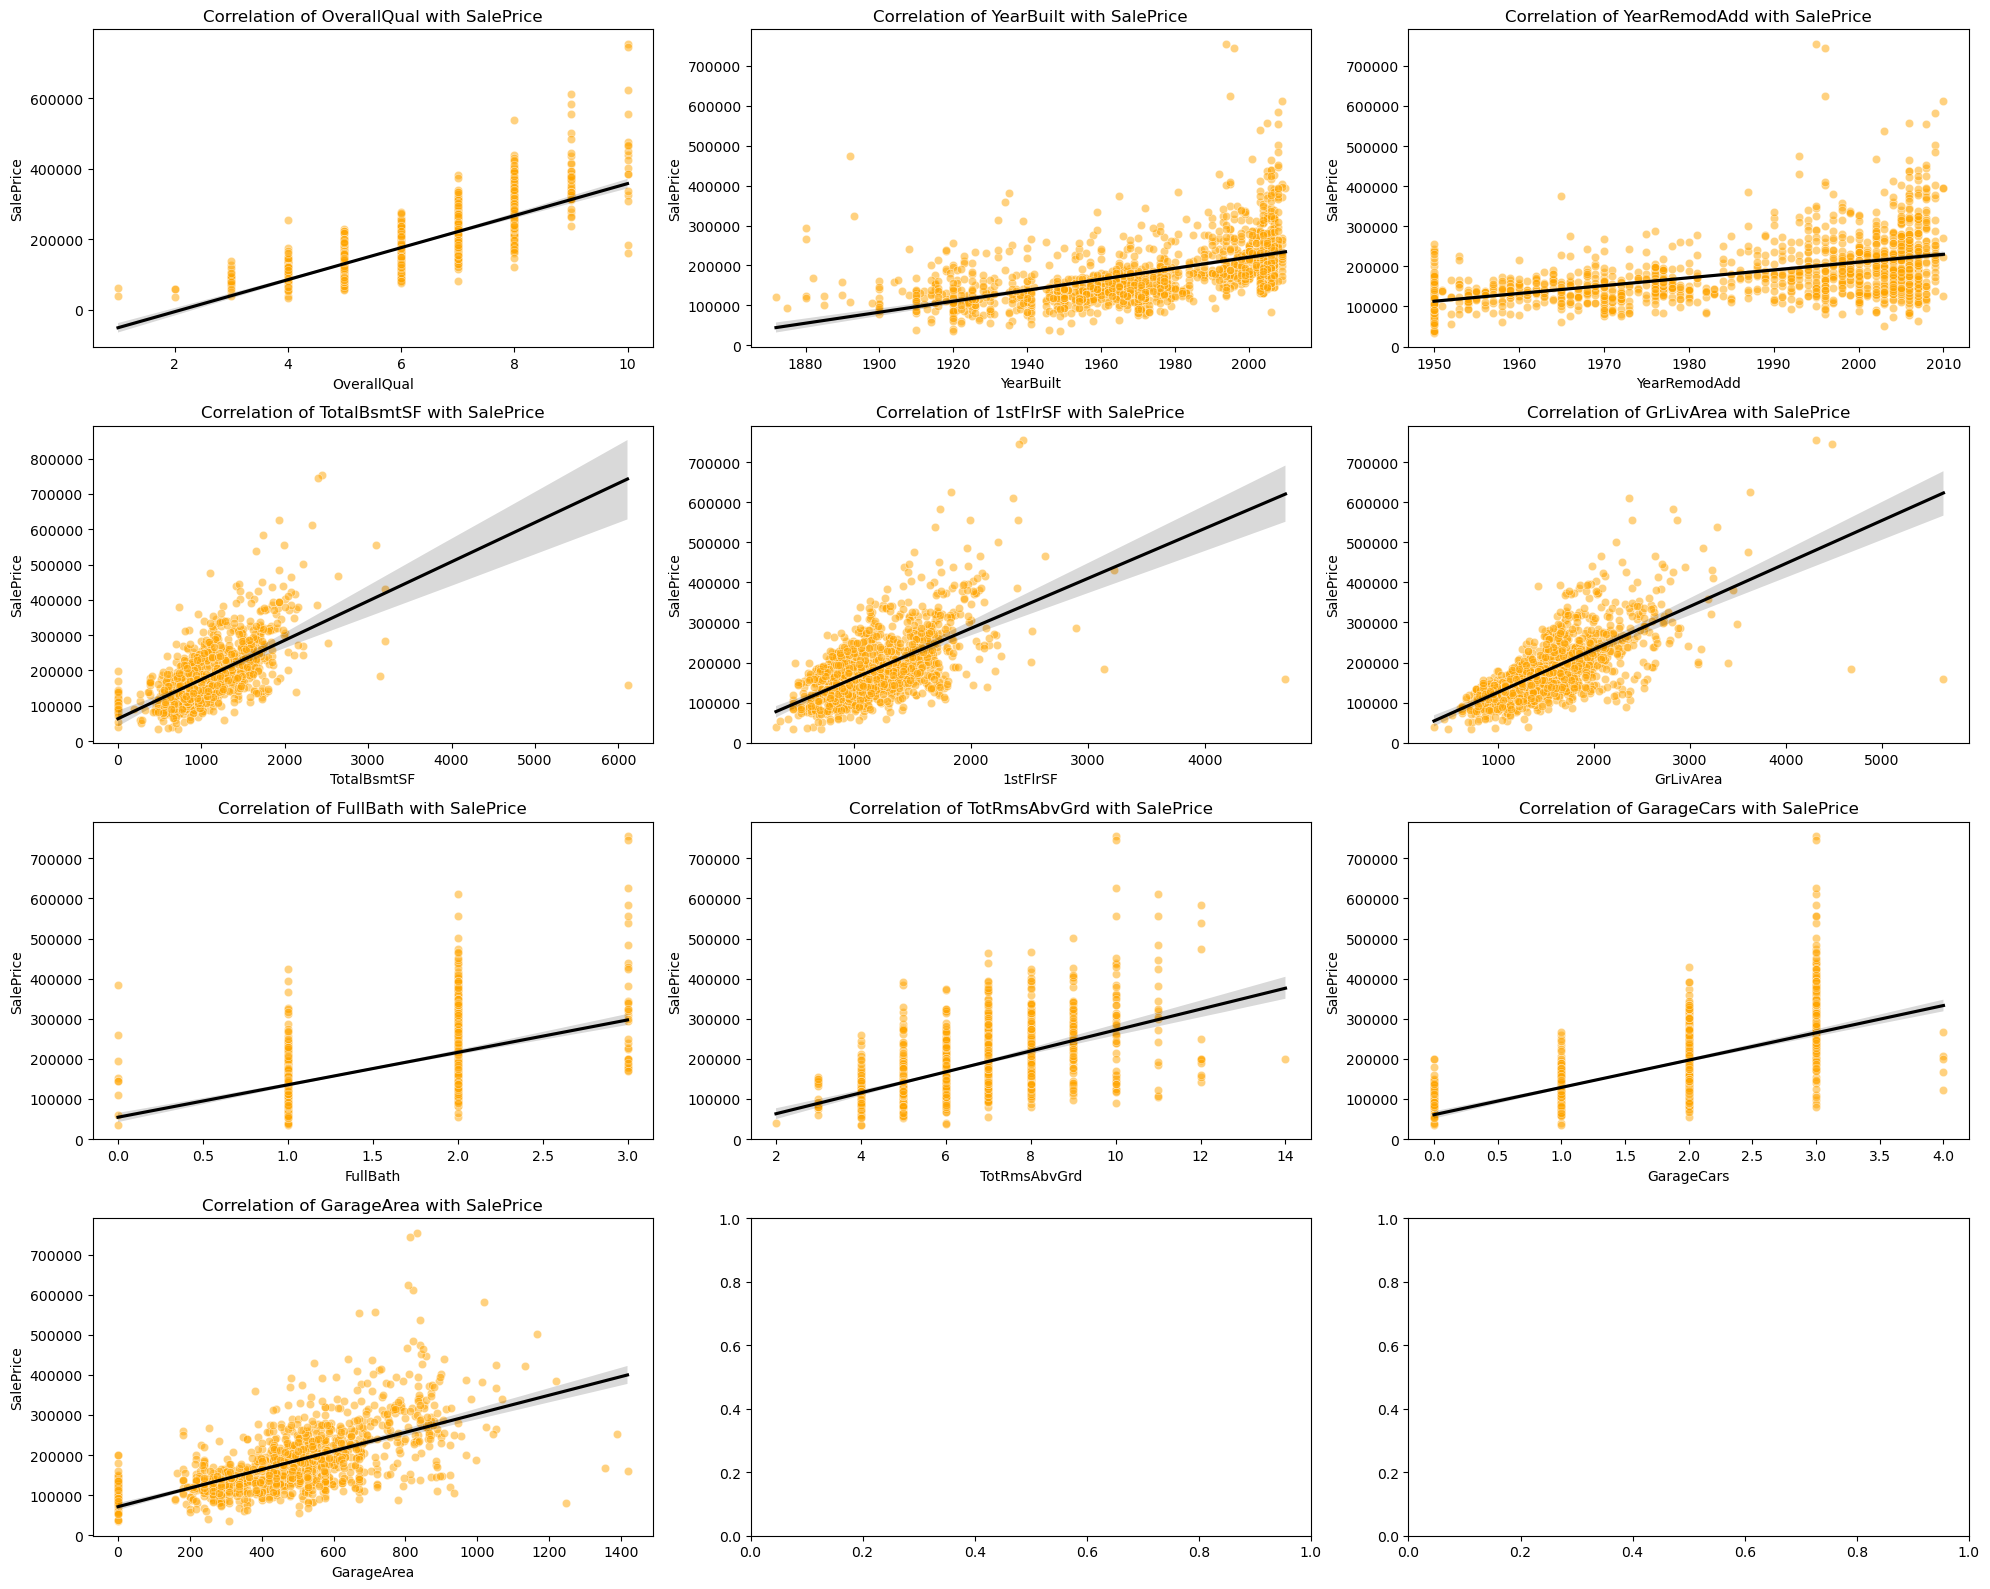

In [22]:
# Create a subset of the filtered data with only the correlated columns
subset_data = train[relevant_cols]

# Set the number of columns for subplots
num_cols = 3  # Choose the number of columns you want
num_rows = int(np.ceil(len(relevant_cols) / num_cols))

# Adjust the size of the figure based on the number of columns and rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

# Plot scatter plots for correlated columns
for i, col in enumerate(subset_data.columns.drop("SalePrice")):
    row_idx = i // num_cols
    col_idx = i % num_cols
    sns.scatterplot(x=col, y="SalePrice", data=subset_data, ax=axes[row_idx, col_idx], alpha=0.5, color='orange')
    # Add the correlation line
    sns.regplot(x=col, y="SalePrice", data=subset_data, ax=axes[row_idx, col_idx], scatter=False, color='black')
    # Add a title to the subplot
    axes[row_idx, col_idx].set_title(f'Correlation of {col} with SalePrice')

# Adjust the layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()

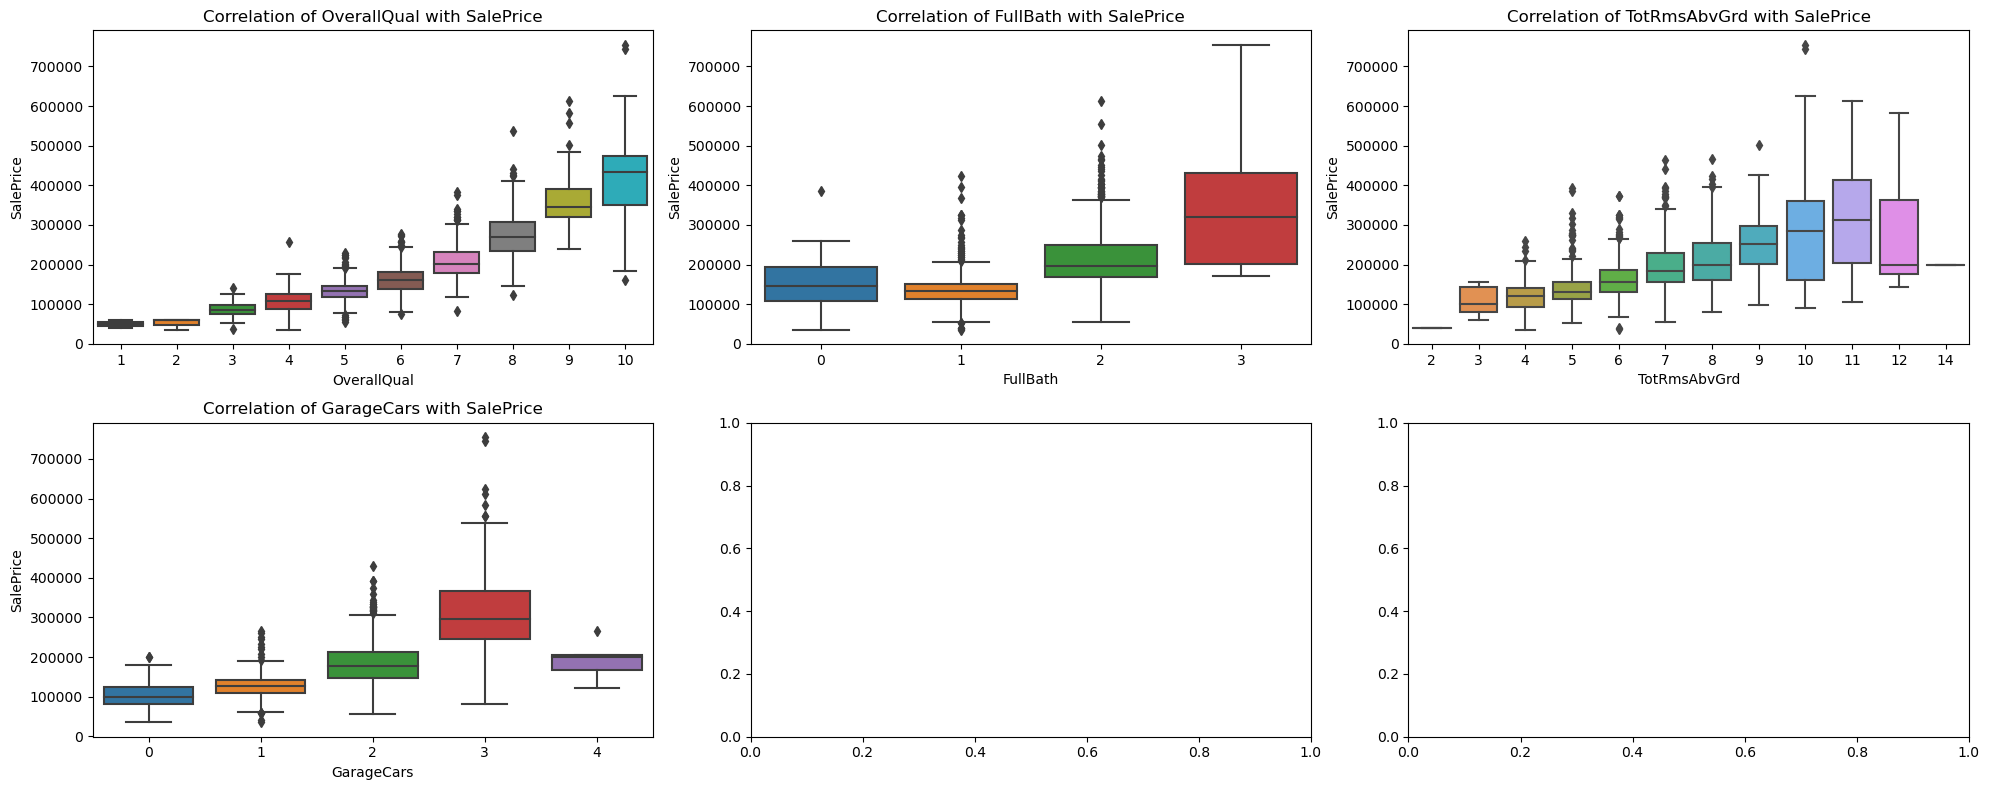

In [23]:
cat_relv_cols = ['OverallQual','FullBath', 'TotRmsAbvGrd', 'GarageCars',"SalePrice"]
# Create a subset of the filtered data with only the correlated columns
subset_data = train[cat_relv_cols]

# Set the number of columns for subplots
num_cols = 3  # Choose the number of columns you want
num_rows = int(np.ceil(len(cat_relv_cols) / num_cols))

# Adjust the size of the figure based on the number of columns and rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

# Plot scatter plots for correlated columns
for i, col in enumerate(subset_data.columns.drop("SalePrice")):
    row_idx = i // num_cols
    col_idx = i % num_cols
    sns.boxplot(x=col, y="SalePrice", data=subset_data, ax=axes[row_idx, col_idx])
    # Add a title to the subplot
    axes[row_idx, col_idx].set_title(f'Correlation of {col} with SalePrice')

# Adjust the layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()

## Cleaning Data

In [24]:
print(f'Train data size: {train.shape}')
print(f'Test data size: {test.shape}')

Train data size: (1460, 81)
Test data size: (1459, 80)


In [25]:
data = pd.concat((train, test),axis=0)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [26]:
print(f' data size: {data.shape}')

 data size: (2919, 81)


In [27]:
data_na = (data.isna().sum()/len(data))*100
data_na = data_na.drop(data_na[data_na==0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({"Missing Ratio": data_na})
missing_data

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
SalePrice,49.982871
FireplaceQu,48.646797
LotFrontage,16.649538
GarageCond,5.447071
GarageYrBlt,5.447071
GarageFinish,5.447071


PoolQC : data description says NA means "No Pool"

MiscFeature : data description says NA means "no misc feature"

Alley : data description says NA means "no alley access"

Fence : data description says NA means "no fence"

FireplaceQu : data description says NA means "no fireplace"

LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with "None".

GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0.

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and 

BsmtHalfBath: Replacing missing data with 0.

BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there isn't a basement.

MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'.

Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can 
then safely remove it.

Functional : data description says NA means typical.

Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

Exterior1st and Exterior2nd : Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

SaleType : Fill in again with most frequent which is "WD"

MSSubClass : Na most likely means No building class. We can replace missing values with None

In [28]:
for col in ('MSSubClass',"MasVnrType",'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"FireplaceQu","Fence","Alley","MiscFeature","PoolQC",'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')
    
for col in ('SaleType','Exterior2nd','Exterior1st','KitchenQual','Electrical','MSZoning'):
    data[col] = data[col].fillna(data[col].mode()[0])
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',"MasVnrArea"):
    data[col] = data[col].fillna(0)

data["Functional"] = data["Functional"].fillna("Typ")    

data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

## Feature Engineering

In [29]:
data['MSSubClass'].describe()

count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

This feature was interpreted as numerical when it is actually categorical. The types listed here are codes, not values. Thus, we need to feature transformation with this and many other features.

In [30]:
#MSSubClass =The building class
data['MSSubClass'] = data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
data['OverallCond'] = data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [31]:
data['KitchenQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

Here, data_description.txt comes to the rescue again!

Kitchen Quality:

Ex: Excellent
Gd: Good
TA: Typical/Average
Fa: Fair
Po: Poor
Is a score of "Gd" better than "TA" but worse than "Ex"? I think so, let's encode these labels to give meaning to their specific orders

In [32]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

# Check shape        
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,10,RL,65.0,8450,1,1,3,Lvl,AllPub,...,0,3,4,None,0,4,2,WD,Normal,208500.0
1,2,5,RL,80.0,9600,1,1,3,Lvl,AllPub,...,0,3,4,None,0,7,1,WD,Normal,181500.0
2,3,10,RL,68.0,11250,1,1,0,Lvl,AllPub,...,0,3,4,None,0,11,2,WD,Normal,223500.0
3,4,11,RL,60.0,9550,1,1,0,Lvl,AllPub,...,0,3,4,None,0,4,0,WD,Abnorml,140000.0
4,5,10,RL,84.0,14260,1,1,0,Lvl,AllPub,...,0,3,4,None,0,3,2,WD,Normal,250000.0


In [33]:
data.shape

(2919, 81)

In [34]:
# Adding Total Square Feet feature 
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

In [35]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
0,1,10,RL,65.0,8450,1,1,3,Lvl,AllPub,...,3,4,None,0,4,2,WD,Normal,208500.0,2566.0
1,2,5,RL,80.0,9600,1,1,3,Lvl,AllPub,...,3,4,None,0,7,1,WD,Normal,181500.0,2524.0
2,3,10,RL,68.0,11250,1,1,0,Lvl,AllPub,...,3,4,None,0,11,2,WD,Normal,223500.0,2706.0
3,4,11,RL,60.0,9550,1,1,0,Lvl,AllPub,...,3,4,None,0,4,0,WD,Abnorml,140000.0,2473.0
4,5,10,RL,84.0,14260,1,1,0,Lvl,AllPub,...,3,4,None,0,3,2,WD,Normal,250000.0,3343.0


### Fixing "skewed" features

Text(0.5, 1.0, 'SalePrice distribution')

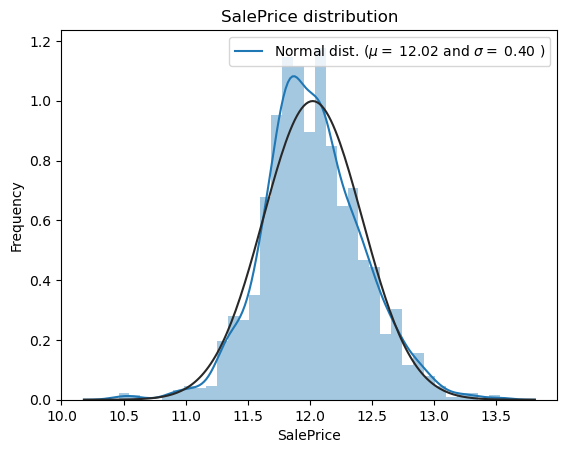

In [36]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.3982596466541509, 12.024057394918403, 0.9953761551826703))

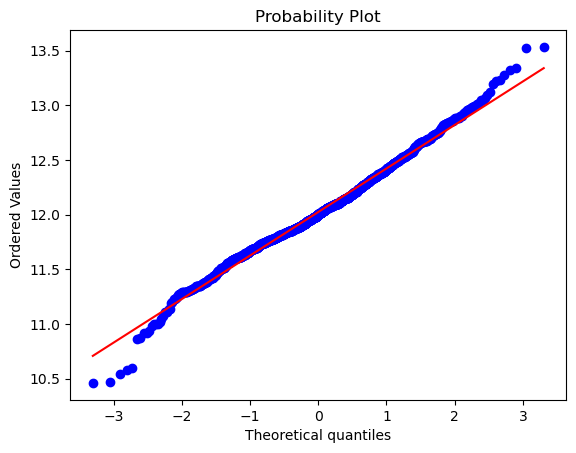

In [37]:
stats.probplot(train['SalePrice'], plot=plt)

In [38]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


In [39]:
numeric_feats = data.dtypes[data.dtypes != "object"].index
# Check the skew of all numerical features
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness

,Skewed Features
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
...,...
GarageCond,-3.595790
GarageYrBlt,-3.906205
Functional,-4.055757
Street,-15.500133


In [40]:
skewness = skewness[abs(skewness)>0.75]
skewness

,Skewed Features
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
...,...
GarageCond,-3.595790
GarageYrBlt,-3.906205
Functional,-4.055757
Street,-15.500133


In [41]:
skewed_features = skewness.index
lam =0.15
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)
    data[feat] += 1

In [42]:
data = pd.get_dummies(data)
data.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.730463,3.885846,6.831328,20.212182,1.730463,1.730463,2.540963,1.0,3.440268,2.820334,...,0,0,0,1,0,0,0,0,1,0
1,2.194318,3.055642,7.221214,20.712205,1.730463,1.730463,2.540963,1.0,3.259674,3.440268,...,0,0,0,1,0,0,0,0,1,0
2,2.540963,3.885846,6.914940,21.347241,1.730463,1.730463,1.000000,1.0,3.440268,2.820334,...,0,0,0,1,0,0,0,0,1,0
3,2.820334,4.011340,6.684507,20.691553,1.730463,1.730463,1.000000,1.0,3.440268,2.820334,...,0,0,0,1,1,0,0,0,0,0
4,3.055642,3.885846,7.314735,22.325160,1.730463,1.730463,1.000000,1.0,3.602594,2.820334,...,0,0,0,1,0,0,0,0,1,0


In [43]:
ntrain = train.shape[0]
ntest = test.shape[0]
train = data[:ntrain]
test = data[ntrain:]

In [44]:
train.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.730463,3.885846,6.831328,20.212182,1.730463,1.730463,2.540963,1.0,3.440268,2.820334,...,0,0,0,1,0,0,0,0,1,0
1,2.194318,3.055642,7.221214,20.712205,1.730463,1.730463,2.540963,1.0,3.259674,3.440268,...,0,0,0,1,0,0,0,0,1,0
2,2.540963,3.885846,6.914940,21.347241,1.730463,1.730463,1.000000,1.0,3.440268,2.820334,...,0,0,0,1,0,0,0,0,1,0
3,2.820334,4.011340,6.684507,20.691553,1.730463,1.730463,1.000000,1.0,3.440268,2.820334,...,0,0,0,1,1,0,0,0,0,0
4,3.055642,3.885846,7.314735,22.325160,1.730463,1.730463,1.000000,1.0,3.602594,2.820334,...,0,0,0,1,0,0,0,0,1,0


## Modeling and Predicting

In [45]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [46]:
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005,l1_ratio=0.9,random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55)

In [47]:
y_train = train.SalePrice.values
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.0007 (0.0000)

ElasticNet score: 0.0008 (0.0000)

Kernel Ridge score: 0.0463 (0.0047)

Gradient Boosting score: 0.4657 (0.0627)

Xgboost score: 0.3999 (0.0436)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 144
[LightGBM] [Info] Start training from score 34.868028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1550
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 141
[LightGBM] [Info] Start training from score 34.875950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of